# Syllable Extraction

In [1]:
# Import the required libraries
# general libs
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import mysql.connector as sql
import ast
from collections import Counter

# text related
import turkishnlp
from turkishnlp import detector
import string
import re
import multidict as multidict

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

# Make database queries

We have three sources:  
* Call center
* YouTube
* Mozilla <br>

Each of these records are stored in a different table there we need three queries to fetch all the data.

In [2]:
db_connection = sql.connect(host='agmysqldb.cor0e0izqy9v.eu-central-1.rds.amazonaws.com', database='agmysqldb',
                            user='agmysqldb', password='agmysqldb3609')
# ...from call center table
query_CC = """
SELECT filePath, transcribe_Json
FROM callcenterFiles
WHERE transcribe_Json IS NOT NULL
"""

# ...from youtube table
query_YT = """
SELECT filePath, transcribe_Json
FROM youtubeFiles
WHERE transcribe_Json IS NOT NULL
"""

# ...from mozilla table
query_MZ = """
SELECT filePath, transcribe_Json
FROM mozillaFiles
WHERE transcribe_Json IS NOT NULL
"""

## Put data in a DataFrame
The data from the three tables are concatenated to for a sigle data frame

In [3]:
# call center df
df_transcribe_CC = pd.read_sql(query_CC, db_connection)
df_transcribe_CC['transcribe_Json'] = [ast.literal_eval(
    i) for i in df_transcribe_CC['transcribe_Json'].values]

# youtube df
df_transcribe_YT = pd.read_sql(query_YT, db_connection)
df_transcribe_YT['transcribe_Json'] = [ast.literal_eval(
    i) for i in df_transcribe_YT['transcribe_Json'].values]

# mozilla df
df_transcribe_MZ = pd.read_sql(query_MZ, db_connection)
df_transcribe_MZ['transcribe_Json'] = [ast.literal_eval(
    i) for i in df_transcribe_MZ['transcribe_Json'].values]

# form one df and view it
df_transcribe = pd.concat([df_transcribe_MZ, df_transcribe_YT, df_transcribe_CC], ignore_index=True, axis=0)
df_transcribe.head()

,filePath,transcribe_Json
0,000ab67c64cfbc124dd666c75d086ce2b0562b69dff948...,{'transcription': {'date': '2019-07-02 09:47:5...
1,001e3f584aa05acd34a754b2425b8301658956f0473e20...,{'transcription': {'date': '2019-07-01 14:00:4...
2,004d5e6f666d6bd3dc57f8d57fb3191862c79af7f2027f...,{'transcription': {'date': '2019-07-04 13:26:2...
3,00a866a9153127b5bd958be695909c108c32cf42ba63ef...,{'transcription': {'date': '2019-07-02 10:18:1...
4,00addca96ab0f24ff8a353e5f0bc53845f7bb950f841c1...,{'transcription': {'date': '2019-07-04 11:13:5...


### Deal with data types

In [4]:
# flatten the json field
new_df = json_normalize(data=df_transcribe['transcribe_Json'])
new_df.columns = ['Date', 'Transcriber', 'Transcription']
df = pd.concat([df_transcribe, new_df], axis=1).drop(['transcribe_Json'], axis=1)

# convert data field to datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,filePath,Date,Transcriber,Transcription
0,000ab67c64cfbc124dd666c75d086ce2b0562b69dff948...,2019-07-02 09:47:58,100788201671814894746,o zamandan beri ara sıra seyyar satıcılık yapmış
1,001e3f584aa05acd34a754b2425b8301658956f0473e20...,2019-07-01 14:00:48,100788201671814894746,öncelikle karşılıklı güven sağlanmalı
2,004d5e6f666d6bd3dc57f8d57fb3191862c79af7f2027f...,2019-07-04 13:26:28,100788201671814894746,sırbistan için yeni bir yol ayrımı mı
3,00a866a9153127b5bd958be695909c108c32cf42ba63ef...,2019-07-02 10:18:12,100788201671814894746,festivale balkanlardan da gelenler oldu
4,00addca96ab0f24ff8a353e5f0bc53845f7bb950f841c1...,2019-07-04 11:13:55,100788201671814894746,grup üyesi birçok kişi tutuklandı


In [5]:
# confirm data types
df.dtypes

filePath                 object
Date             datetime64[ns]
Transcriber              object
Transcription            object
dtype: object

## Extract syllables
Syllables are extacted using the **TurkishNLP** library  
We will create a dictionary of syllables and words from our database

In [6]:
# create a syllable extraction instance
obj = detector.TurkishNLP()

In [7]:
# text from db
doc = " ".join(df.Transcription.values)
# remove punctuation and leading space
words = doc.translate(str.maketrans('', '', string.punctuation))[1:].lower()

# create the syllables from the words
syllables = obj.syllabicate_sentence(words)

# Make syllables into a sigle  long list
Syllables = [item for slb in syllables for item in slb]

## Create syllable dictionary

In [9]:
# Create a data frame for to analyse the syllables
df_syllables = pd.DataFrame()
df_syllables["Syllable"] = Counter(Syllables).keys()
df_syllables["Occurence"] = Counter(Syllables).values()

# sort based on the number of occurences of each syllable
df_syllables.sort_values(by=['Occurence'],ascending=False).reset_index(drop=True).head(50)

,Syllable,Occurence
0,la,1619
1,de,1505
2,le,1461
3,da,1235
4,bi,1196
5,ya,1169
6,a,1137
7,di,1005
8,i,962
9,o,924


In [10]:
# No of transcriptions available
print(f"Transcriptions: {df.shape[0]}")
print(f"Unique words: {len(Counter(words.split()).keys())}")
print(f"Unique syllables {df_syllables.shape[0]}")

Transcriptions: 2974
Unique words: 8643
Unique syllables 1543


### Use regular exressions to explore the dataframe

In [23]:
pattern = r're'
df_syllables[df_syllables.Syllable.str.contains(pattern)]

,Syllable,Occurence
95,ret,33
130,rek,263
141,re,470
215,rev,18
255,rey,12
309,rel,4
383,red,8
397,reç,6
423,rep,2
612,ren,31


# Visualization
Word clouds are created to visualize the words and syllables

## Syllable-level Word Cloud

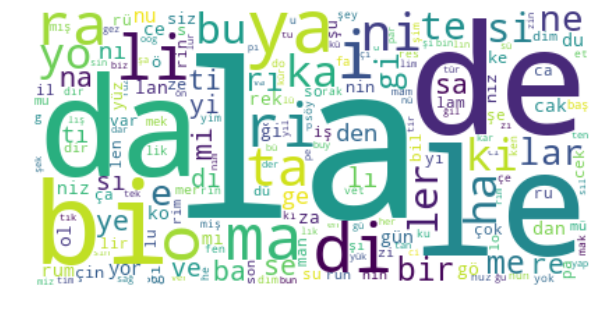

In [12]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

def makeImage(text):
    
    wc = WordCloud(background_color="white")
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.figure(figsize=[10,7])
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


makeImage(getFrequencyDictForText(" ".join(Syllables)))

## Word-level word cloud

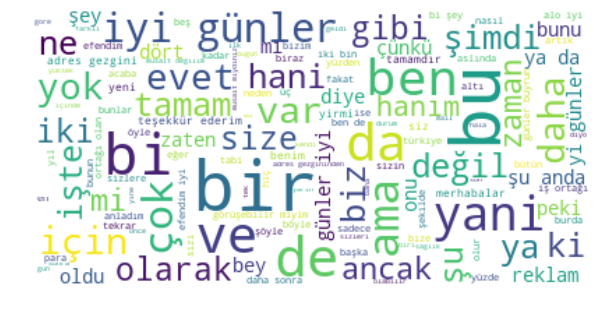

In [13]:
# Create stopword list:
# stopwords = set(STOPWORDS)
# stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, background_color="white").generate(words)

# Display the generated image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()